In [127]:
import numpy as np
import copy
import time
class Node:
    def __init__(self):
        '''dimension can be passed to create the node'''
        self.node = np.zeros([3,3], dtype = int)
        ''' node for children based on operators'''
        self.up = None
        self.down = None
        self.left = None
        self.right = None
        ''' save the parent to compute the depth'''
        self.parent = None
        '''h_t = misplaced tile distance, h_m = manhattan distance, g = distance from the root, f for a*'''
        self.g = 0
        self.h_t = 0
        self.h_m = 0
        self.f = 0
        
    def misplacedTile(self,goal):
        self.goal = goal
        '''Compute the Mispalced tile heuristics with the help of the goal.
        Numpy uses all() to compare if each nd array is the same.
        We find the sum of the nd-array which is different from the goal state and return the result'''
        if not (self.node == self.goal).all():
            self.h_t = np.sum(self.node!=self.goal)
        return self.h_t
    
    def manhattan(self, goal):
        self.goal = goal 
        '''Instead of 3 we can use dimension value. 
        Compute the Manhattan distance heuristics with the goal and the node.
        Each position is checked and computed for the positional change required in the nd array.
        '''
        for i in range(0,3):
            for j in range(0,3):
                m,n = np.where(self.node==goal[i][j])
                if(goal[i][j]!=0):
                    self.h_m += abs(i-m[0])+abs(j-n[0])
        return self.h_m

def genChild(i, j, node, goal):
    '''Generate children based on the i,j (position of the blank).
    We can move up only if there is space above. Similary we compute child possiblity based on the i,j value.
    If the child is possible based on the operation create a node and swap with the blank. Then compute manhattan 
    and misplaced tile heuristics. Add the parent to the node and increase of the cost g(n) by 1 
    as we've generated the child
    '''
    #up=>i-1
    if i>0:
        child = copy.deepcopy(node.node)
        x = i-1
        child[i,j], child[x,j] = child[x,j], child[i,j]
        node.up = Node()
        node.up.node = child
        node.up.misplacedTile(goal)
        node.up.manhattan(goal)
        node.up.parent = node
        node.up.g = node.g+1
    #down=>i+1
    if i<2:
        child = copy.deepcopy(node.node)
        x = i+1
        child[i,j], child[x,j] = child[x,j], child[i,j]
        node.down = Node()
        node.down.node = child
        node.down.misplacedTile(goal)
        node.down.manhattan(goal)
        node.down.parent = node
        node.down.g = node.g+1
    #left=>j-1
    if j>0:       
        child = copy.deepcopy(node.node)
        x = j-1
        child[i,j],child[i,x] = child[i,x], child[i,j]
        node.left = Node()
        node.left.node = child
        node.left.misplacedTile(goal)
        node.left.manhattan(goal)
        node.left.parent = node
        node.left.g = node.g+1
    #right=>j+1
    if j<2:
        child = copy.deepcopy(node.node)
        x = j+1
        child[i,j],child[i,x] = child[i,x], child[i,j]
        node.right = Node()
        node.right.node = child
        node.right.misplacedTile(goal)
        node.right.manhattan(goal)
        node.right.parent = node
        node.right.g = node.g+1

def calculateFTile(node):
    '''Since at times we might encounter nodes with less children(corner and edge cases), we check for the 
    node generation and calculate the f(n) for the misplaced tile, so we use h_t
    '''
    a = b = c = d = float("inf")
    if node.up is not None:
            a = node.up.h_t + node.up.g
            node.up.f = a
    if node.down is not None:
            b = node.down.h_t + node.down.g
            node.down.f = b
    if node.left is not None:
            c = node.left.h_t + node.left.g
            node.left.f = c
    if node.right is not None:
            d = node.right.h_t + node.right.g
            node.right.f = d
    return min(a,b,c,d)

def calculateFmanhattan(node):
    '''Since at times we might encounter nodes with less children(corner and edge cases), we check for the 
    node generation and calculate the f(n) for the manhattan distacne, so we use h_m.
    '''
    a = b = c = d = float("inf")
    if node.up is not None:
        a = node.up.h_m + node.up.g
        node.up.f = a
    if node.down is not None:            
        b = node.down.h_m + node.down.g
        node.down.f = b
    if node.left is not None:            
        c = node.left.h_m + node.left.g
        node.left.f = c
    if node.right is not None:            
        d = node.right.h_m + node.right.g
        node.right.f = d
    return min(a,b,c,d)

def calculateFUCS(node):
    '''Since at times we might encounter nodes with less children(corner and edge cases), we check for the 
    node generation and calculate the f(n) for the Uniform Cost Search, so we do not use h.
    '''
    a = b = c = d = float("inf")
    if node.up is not None:
        a = node.up.g
        node.up.f = a
    if node.down is not None:            
        b = node.down.g
        node.down.f = b
    if node.left is not None:            
        c = node.left.g
        node.left.f = c
    if node.right is not None:            
        d = node.right.g
        node.right.f = d
    return min(a,b,c,d)

def nodesToExpand(node, states):
    '''If the generate nodes are not present in the states(which are the nodes that are already explored, 
    if the generated node is in the states, it is a repeated state and can be ignored) we add it to the queue.
    '''
    includednodes = []
    if node.up is not None:
        if not any([np.array_equal(node.up.node, state) for state in states]):
            includednodes.append(node.up)
    if node.down is not None:
        if not any([np.array_equal(node.down.node, state) for state in states]):
            includednodes.append(node.down)
    if node.left is not None:
        if not any([np.array_equal(node.left.node, state) for state in states]):
            includednodes.append(node.left)
    if node.right is not None:
        if not any([np.array_equal(node.right.node, state) for state in states]):
            includednodes.append(node.right)
    return includednodes

def depth(node):
    '''Compute the node depth based on the parent and increase the d value.'''
    d = 0
    n = node
    while n.parent is not None:
        d+=1
        n = n.parent
    print("depth=",d)
    return d

def solve(startNode, goal):
    ''' This is where we solve the puzzle'''
    '''Algorithm options: 
    0 = Uniform Cost Search, 
    1 = A* with Misplaced Tile
    2 = A* with Manhattan Distance'''
    algorithm_options = [0,1,2]
    ''' Node expanded, max queue and the time executed size for each algorithm for every input'''
    nodes_expanded = []
    max_queue = []
    time_list = []
    '''Each algorithm has to run for each input'''
    for choice in algorithm_options:
        states = [startNode.node]
        '''create a queue q.'''
        q = []
        #end time
        e = 0
        #node inserted
        q.append(startNode)
        #queue count
        max_q = 0
        node = startNode
        #start from the dequeued node
        q.pop(0)
        while(1):
            '''If the goal state and the node are equal, we have reached a solution.'''
            if (node.node==goal).all():
                d = (depth(node))
                break
            '''find the 0 as it is where the blank is present and we can perform operations based on the blank.'''
            i,j = np.where(node.node==0)
            #Generate child for each node
            genChild(i, j, node, goal)
            #start the time
            s = time.time()
            '''Based on the choice compute the f(n)'''
            if choice == 0:
                f = calculateFUCS(node)
            elif choice==1:
                f = calculateFTile(node)
            else:
                f = calculateFmanhattan(node)
            '''Nodes to added based on the f(n) and to check if it is not a repeated state. 
            The returned nodes are added to the queue for further exploration'''    
            qnodes = nodesToExpand(node,states)
            for n in qnodes:
                q.append(n)
            '''We sort the elements in the queue based on the f. 
            As we always get to a solution based on the minimum f(n)'''
            q.sort(key = lambda x: x.f)
            '''max queue length calculation'''
            max_q = max(len(q),max_q)
            '''If the Queue is empty we can not find the solution so break.'''
            if len(q)==0: 
                print("Can not find a solution!")
                break
            '''Dequeue the next element in the queue.'''
            node = q.pop(0)
            '''Since we are processing the node, add it to the states explored'''
            states.append(node.node)
            '''if the node is the goal state, calculate the depth and stop the time and break the loop.'''
            if (node.node==goal).all():
                d = depth(node)
                e = time.time() - s
                break
        '''Add the values with the algorithm so it will be easy to plot'''
        nodes_expanded.append([choice, len(states)])
        max_queue.append([choice, max_q])
        time_list.append([choice,e])
    print(nodes_expanded)
    print(max_queue)
    print(time_list)
    return nodes_expanded, max_queue, d, time_list
   
''' Lists of Inputs at different Depth ''' 
#We can also get the input from the user. use input(). 0 presents Blank
inputs = ["1,2,3,4,5,6,7,8,0",
          "1,2,3,4,5,6,0,7,8",
          "1,2,3,5,0,6,4,7,8",
          "1,3,6,5,0,2,4,7,8", 
          "1,3,6,5,0,7,4,8,2",
          "1,6,7,5,0,3,4,8,2",
          #"7,1,2,4,8,5,6,3,0",
          #"0,7,2,4,6,1,3,5,8"
         ]
''' 8 puzzle problem so dimension is equal to 3 '''
dim = 3
''' Node expanded, max queue and the time executed size for each algorithm for every input'''
nodes_expanded = []
max_queue = []
time_list = []

'''depth of each input'''
input_depth = []

'''Solve for each input'''
for i in inputs:
    intial = i
    #Convert String to a list
    intial = list(map(int,intial.split(",")))
    #Create the initial state as the start node with Type Node (User Defined Class) object
    startNode = Node()
    #Convert the list to a nd-array using numpy
    startNode.node = np.asarray(intial).reshape(dim, dim)

    '''Create Goal state based on the dimension or get the goal from the user'''
    goal = np.arange(1,(dim*dim)+1,1).reshape(dim, dim)
    goal[dim-1][dim-1] = 0

    '''n = Nodes expanded, m = max queue size, d =depth, t = time returned after solving 
    for the input using different algorithms. Save the result'''
    n, m, d, t = solve(startNode, goal)
    nodes_expanded.append(n)
    max_queue.append(m)
    input_depth.append(d)
    time_list.append(t)
    
    '''Save the state to a file'''
    file = open("8puzzle.txt","a")
    file.writelines("\n"+i+"\nNode expanded:"+str(n)+"\nMax Queue:"+str(m)+"\nDepth:"+str(d)+"\n")
    file.close()

Enter 9 numbers , seperated:
depth= 0
depth= 0
depth= 0
[[0, 1], [1, 1], [2, 1]]
[[0, 0], [1, 0], [2, 0]]
[[0, 0], [1, 0], [2, 0]]
depth= 2
depth= 2
depth= 2
[[0, 7], [1, 3], [2, 3]]
[[0, 8], [1, 3], [2, 3]]
[[0, 9.179115295410156e-05], [1, 3.790855407714844e-05], [2, 3.2901763916015625e-05]]
depth= 4
depth= 4
depth= 4
[[0, 33], [1, 5], [2, 5]]
[[0, 28], [1, 6], [2, 6]]
[[0, 0.0003719329833984375], [1, 4.601478576660156e-05], [2, 7.009506225585938e-05]]
depth= 8
depth= 8
depth= 8
[[0, 321], [1, 20], [2, 13]]
[[0, 210], [1, 16], [2, 12]]
[[0, 0.0030400753021240234], [1, 0.00015282630920410156], [2, 0.00010800361633300781]]
depth= 12
depth= 12
depth= 12
[[0, 2569], [1, 135], [2, 37]]
[[0, 1520], [1, 88], [2, 28]]
[[0, 0.02435612678527832], [1, 0.0009648799896240234], [2, 0.0002701282501220703]]
depth= 16
depth= 16
depth= 16
[[0, 16840], [1, 740], [2, 97]]
[[0, 9180], [1, 445], [2, 64]]
[[0, 0.09913492202758789], [1, 0.0036220550537109375], [2, 0.00043702125549316406]]


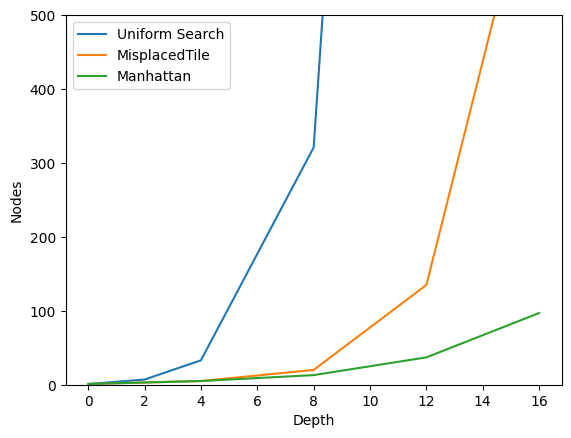

In [118]:
import matplotlib.pyplot as p
'''Graph plotting.
3 list for 3 algorithms'''
node_ucs = []
node_tile = []
node_man = []

for node in nodes_expanded:
    node_ucs.append(node[0][1])
    node_tile.append(node[1][1])
    node_man.append(node[2][1])
depth = [0,2,4,8,12,16]
p.plot(depth, node_ucs, label = "Uniform Search")
p.plot(depth, node_tile, label = "MisplacedTile")
p.plot(depth, node_man, label = "Manhattan")
#for a detailed view of the A* algorithm
p.ylim(0,500)
#To get a clear overview of the algorithm. Uncomment if necessary
#p.yscale("log")
p.xlabel("Depth")
p.ylabel("Nodes")
p.legend()
p.show()

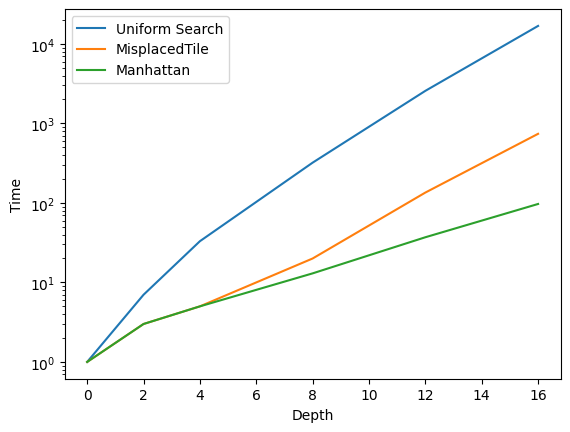

In [128]:
import matplotlib.pyplot as p
time = []
time1 = []
time2 = []
time3 = []
for t in time_list:
    time1.append(t[0][1])
    time2.append(t[1][1])
    time3.append(t[2][1])
depth = [0,2,4,8,12,16]
p.plot(depth, node_ucs, label = "Uniform Search")
p.plot(depth, node_tile, label = "MisplacedTile")
p.plot(depth, node_man, label = "Manhattan")
#p.ylim(0,500)
p.yscale("log")
p.xlabel("Depth")
p.ylabel("Time")
p.legend()
p.show()